100%|██████████| 82/82 [14:50<00:00, 10.85s/it]


type_site
tumor_large_intestine       14
tumor_lung                  12
tumor_gynecologic           10
tumor_haematopoietic         9
tumor_breast                 5
normal_brain                 5
tumor_male_genital_tract     4
normal_kidney                3
tumor_skin                   3
normal_muscle                3
normal_skin                  2
normal_adipose               2
normal_breast                2
tumor_liver                  2
normal_bone                  2
tumor_bone                   1
tumor_stomach                1
normal                       1
normal_liver                 1
Name: count, dtype: int64


/home/masato-tsutsui/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


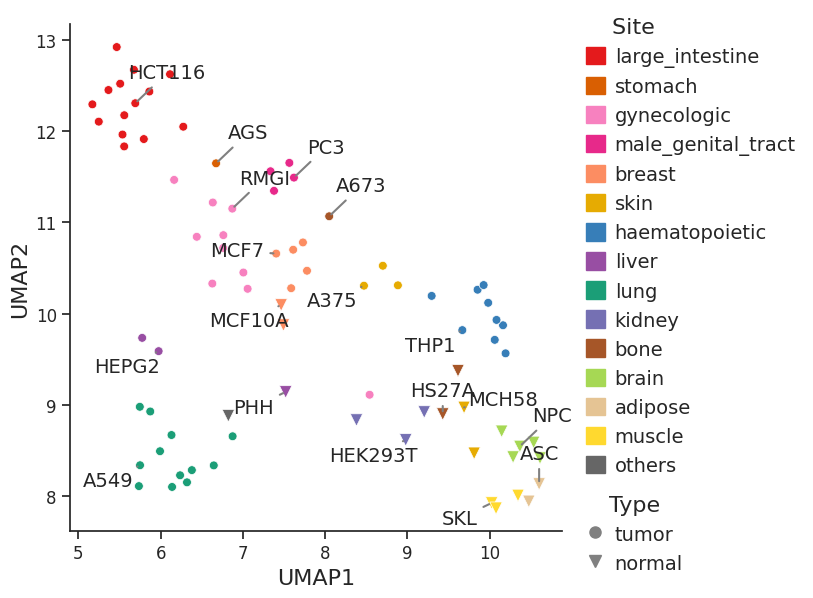

In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import TruncatedSVD
from umap import UMAP
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['lines.linewidth'] = 2.0


#######################
# Load gene relation network
#######################
relations_df = pd.read_csv("../data/fig2-3/all_human_gene_interactions_2024-12-18.csv")
relations_df["pair"] = relations_df.apply(lambda x: "--".join(sorted([str(x["from_gene"]), str(x["to_gene"])])), axis=1)
relations_df = relations_df.drop_duplicates(subset=["pmid", "pair"]).reset_index(drop=True)


#####################
# Load PMID-celltype correlations
#####################
threshold = 0.1
pmid_corrs = pd.read_parquet("../data/fig5/cellline_pmid_bert_corrs.parquet")
pmid_corrs = pmid_corrs.set_index("pmid")

celltypes_rel_net = []
celltypes = np.array(pmid_corrs.columns)
for celltype in tqdm(pmid_corrs.columns):
    celltype_relations = relations_df.copy()
    celltype_relations["corr"] = celltype_relations["pmid"].map(pmid_corrs[celltype])

    celltype_relations = celltype_relations.dropna(subset=["corr"]).reset_index(drop=True)
    # Thresholding
    celltype_relations = celltype_relations[celltype_relations["corr"] > threshold].reset_index(drop=True)

    # Calculate context-dependent weights
    celltype_relations["pair"] = celltype_relations.apply(lambda x: "--".join(sorted([str(x["from_gene"]), str(x["to_gene"])])), axis=1)
    celltype_relations = celltype_relations.drop_duplicates(subset=["pmid", "pair"]).reset_index(drop=True)
    
    # count relations
    celltype_relations = celltype_relations[["pair", "corr"]].groupby("pair").agg({"corr": "sum"}).reset_index()
    celltype_relations["corr"] = celltype_relations["corr"] / celltype_relations["corr"].sum() * 1e6
    # Log transformation to make the distribution more normal
    celltype_relations["corr"] = np.log1p(celltype_relations["corr"].values)
    # rename
    celltype_relations.columns = ["pair", celltype]
    celltype_relations = celltype_relations.set_index("pair")
    celltypes_rel_net.append(celltype_relations)
celltypes_rel_net = pd.concat(celltypes_rel_net, axis=1)

############################
# Load cell type information
############################
cellinfo_df = pd.read_csv("../data/fig5/cell_info.csv")
cellinfo_df["tumor_normal"] = cellinfo_df["type_site"].apply(lambda x: x.split("_")[0])
cellinfo_df["site"] = cellinfo_df["type_site"].apply(lambda x: "_".join(x.split("_")[1:]) if len(x.split("_")) > 1 else "others")

print(cellinfo_df["type_site"].value_counts())

#####################
# Visualization
#####################
# Dimensionality reduction
relation_values = celltypes_rel_net.fillna(0).values.T
svd = TruncatedSVD(n_components=200, random_state=42)
relation_values_svd = svd.fit_transform(relation_values)
umap_coord = UMAP(n_components=2, random_state=42).fit_transform(relation_values_svd)

repr_cells = ["ASC", "HS27A", "NPC", "MCF10A", "HEK293T", "PHH",
              "SKL", "MCH58", "A673", "MCF7", "RMGI", "THP1", "HCT116",
              "HEPG2", "A549", "PC3", "A375", "AGS"]

cellinfo_df["tumor_normal"] = cellinfo_df["type_site"].apply(lambda x: x.split("_")[0])
cellinfo_df["site"] = cellinfo_df["type_site"].apply(lambda x: "_".join(x.split("_")[1:]) if len(x.split("_")) > 1 else "others")

site_order = ["large_intestine", "stomach", "gynecologic", "male_genital_tract", "breast", "skin", "haematopoietic", "liver", "lung", "kidney", "bone", "brain", "adipose", "muscle", "others"]

custom_palette = {
    "large_intestine": sns.color_palette("Set1")[0],
    "stomach": sns.color_palette("Dark2")[1],
    "gynecologic": sns.color_palette("Set1")[-2],
    "male_genital_tract": sns.color_palette("Dark2")[3],
    "breast": sns.color_palette("Set2")[1],
    "skin": sns.color_palette("Dark2")[-3],
    "haematopoietic": sns.color_palette("Set1")[1],
    "liver": sns.color_palette("Set1")[3],
    "lung": sns.color_palette("Dark2")[0],
    "kidney": sns.color_palette("Dark2")[2],
    "bone": sns.color_palette("Set1")[-3],
    "brain": sns.color_palette("Set2")[-4],
    "adipose": sns.color_palette("Set2")[-2],
    "muscle": sns.color_palette("Set2")[-3],
    "others": sns.color_palette("Dark2")[-1]
    }

fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(x=umap_coord[:, 0], y=umap_coord[:, 1],
                hue=cellinfo_df["site"].values,
                hue_order=site_order,
                style=cellinfo_df["tumor_normal"],
                markers={"tumor": "o", "normal": "v"},
                size=cellinfo_df["tumor_normal"].apply(lambda x: 40 if "tumor" in x else 80),
                sizes=(40, 80),
                palette=custom_palette, ax=ax, legend=False)



hue_handles = [
    mpatches.Patch(color=custom_palette[site], label=site)
    for site in site_order
]

style_handles = [
    mlines.Line2D([], [], color="gray", marker="o", linestyle='None', markersize=8, label="tumor"),
    mlines.Line2D([], [], color="gray", marker="v", linestyle='None', markersize=8, label="normal"),
]

legend1 = fig.legend(
    handles=hue_handles, title="Site                ",
    loc="center left", bbox_to_anchor=(0.96, 0.6),
    frameon=False, handlelength=1.0, handleheight=1.0,
    handletextpad=0.5, fontsize=14, title_fontsize=16
)

legend2 = fig.legend(
    handles=style_handles, title="Type",
    loc="center left", bbox_to_anchor=(0.96, 0.12),
    frameon=False, handlelength=1.0, handleheight=1.0,
    handletextpad=0.5, fontsize=14, title_fontsize=16
)

# Add text labels for representative cell types
right_pos_celllines = ["HCT116", "AGS", "PC3", "A673", "MCH58", "NPC", "ASC", "RMGI"]
xytext = (

)
for idx in repr_cells:
    idx = np.where(celltypes == idx)[0][0]
    celltype = celltypes[idx]
    if celltype == "HS27A":
        xytext = (0, 13)
    elif celltype == "ASC":
        xytext = (0, 18)
    elif celltype == "MCH58":
        xytext = (28, 2)
    elif celltype == "MCF7":
        xytext = (-28, -2)
    elif celltype in right_pos_celllines:
        xytext = (23, 18)
    else:
        xytext = (-23, -15)
    x, y = umap_coord[idx]
    ax.annotate(
        celltype,
        (x, y),
        xytext=xytext,
        textcoords="offset points",
        ha='center',
        fontsize=14,
        arrowprops=dict(arrowstyle="-", color="gray", lw=1.5)
    )

ax.set_xlabel("UMAP1", fontsize=16)
ax.set_ylabel("UMAP2", fontsize=16)
ax.grid(False)
fig.tight_layout()
fig.savefig("../data/fig5/fig5.umap_celltype_origin_site.png", dpi=300, bbox_inches="tight")

plt.show()
